# 150 x 150 image net

In [1]:
import os
import PIL
import random
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from random import shuffle
from pathlib import Path
from typing import Callable, Optional
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import Compose, ToTensor, Resize
import torchvision.transforms as transform
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
torch.backends.mps.is_available()

True

In [3]:
class DogsCatsDataset(Dataset):
    def __init__(self,
        image_path: str,
        transform = None,
        target_transform = None,
        train = True
    ):
        random.seed(42)
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        self.image_path = Path(image_path)
        self.pattern = '*.jpg'
        self.pt_cat = self.image_path / 'Cat'
        self.pt_dog = self.image_path / 'Dog'
        self.pt_cat_glob = self.pt_cat.glob(self.pattern)
        self.pt_dog_glob = self.pt_dog.glob(self.pattern)
        self.cat_list = list(self.pt_cat_glob)
        self.dog_list = list(self.pt_dog_glob)
        shuffle(self.cat_list)
        shuffle(self.dog_list)
        self.len_cat = int(0.8*len(self.cat_list))
        self.len_dog = int(0.8*len(self.dog_list))
        if train:
            self.image_list = self.cat_list[:self.len_cat] + self.dog_list[:self.len_dog]
        else:
            self.image_list = self.cat_list[self.len_cat:] + self.dog_list[self.len_dog:]
        
    def __len__(self):
        # pt_cat = self.image_path / 'Cat'
        # pt_dog = self.image_path / 'Dog'
        # len_ = len(list(pt_dog.glob('*'))) + len(list(pt_cat.glob('*')))
        return len(self.image_list)
    
    def __getitem__(self, idx):
        image = PIL.Image.open(str(self.image_list[idx])).convert('RGB')
        if self.train:
            label = int(idx >= self.len_cat)
        else:
            label = int(idx >= len(self.cat_list)-self.len_cat)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [45]:
transform = Compose([ToTensor(), Resize([150, 150])])

In [47]:
train_data = DogsCatsDataset(
    image_path='data/kagglecatsanddogs_5340/PetImages',
    transform=transform,
)
test_data = DogsCatsDataset(
    image_path='data/kagglecatsanddogs_5340/PetImages',
    transform=transform,
    train=False
)

In [5]:
def image_acc(net, loader):
    total = 0
    correct = 0
    net.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    with torch.no_grad():
        for data in tqdm(loader):
            images, labels = data
            # print(output.shape, labels.shape)
            output = net(images.to(device))
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()
    net.train()
    # print(total)
    return 100*correct/total

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*34*34, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 8)
        self.fc5 = nn.Linear(8, 2)
        self.dropout_hard = nn.Dropout(0.2)
        self.dropout_light = nn.Dropout(0.075)
        
    def forward(self, x): # bs 3 150 150
        
        x = self.pool(F.relu(self.conv1(x))) # bs 6 73 73
        x = self.dropout_light(x)
        
        x = self.pool(F.relu(self.conv2(x))) # bs 16 34 34
        x = self.dropout_light(x)
        
        x = torch.flatten(x, 1) # bs*16*34*34
        
        x = F.relu(self.fc1(x)) # bs*1024
        x = self.dropout_light(x)
        
        x = F.relu(self.fc2(x)) # bs*256
        x = self.dropout_hard(x)
        
        x = F.relu(self.fc3(x)) # bs*64
        x = self.dropout_light(x)
        
        x = F.relu(self.fc4(x)) # bs*8
        x = self.dropout_hard(x)
        
        x = self.fc5(x) # bs*2
        return x

In [7]:
class Net1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.conv3 = nn.Conv2d(12, 24, 5)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.l_drop = nn.Dropout(0.075)
        self.h_drop = nn.Dropout(0.3)
        
        self.fc1 = nn.Linear(24*15*15, 512)
        self.fc2 = nn.Linear(512, 32)
        self.fc3 = nn.Linear(32, 2)

        
    def forward(self, x): # bs 3 150 150
        
        x = self.pool(F.relu(self.conv1(x))) # bs 6 73 73
        x = self.l_drop(x)
        
        x = self.pool(F.relu(self.conv2(x))) # bs 12 34 34
        x = self.l_drop(x)
        
        x = self.pool(F.relu(self.conv3(x))) # bs 24 15 15
        x = self.l_drop(x)
        
        x = torch.flatten(x, 1) # bs*24*15*15
        
        x = F.relu(self.fc1(x)) # bs 512
        x = self.l_drop(x)
        
        x = F.relu(self.fc2(x)) # bs 32
        x = self.h_drop(x)
        
        x = self.fc3(x) # bs 2
        
        return x
        
        

In [8]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print (x)
else:
    device = torch.device("cpu")
    print ("MPS device not found.")
    

# net = Net()
# net = Net1()
# net = net.to(device)

tensor([1.], device='mps:0')


In [9]:
print(sum(p.numel() for p in net.parameters()))

NameError: name 'net' is not defined

In [10]:
main_loss = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=0.0005)

NameError: name 'net' is not defined

In [14]:
bs = 32

train_loader = DataLoader(
    train_data,
    batch_size=bs,
    shuffle=True,
)

test_loader = DataLoader(
    test_data,
    batch_size=bs,
    shuffle=True,
)

In [12]:
epoch_weight = []
loss_ = []
accuracy = []

In [15]:
def learning(net, optimizer, main_loss, n_epochs, train_loader, loss_history = [], accuracy_history = []):
    loss_ = loss_history
    accuracy = accuracy_history
    dict_ = {
        'loss':'0.0',
        'test':'0.0',
        'train':'0.0'
    }
    for epoch in tqdm(range(n_epochs), total=n_epochs, desc='Learning'):
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}') as pbar:
            for i, data in enumerate(train_loader, 0):
                images, labels = data

                optimizer.zero_grad()

                outputs = net(images.to(device))

                loss = main_loss(outputs, labels.to(device))
                loss.backward()
                optimizer.step()

                # pbar.set_postfix(loss=format(float(loss), '.6f'), , refresh=True)
                
                dict_['loss'] = format(float(loss), '.6f')
                
                pbar.set_postfix(**dict_, refresh=True)
                pbar.update()
                loss_.append(loss)
                
        accuracy.append([image_acc(net, test_loader), image_acc(net, train_loader)])
        dict_['test'] = format(accuracy[-1][0], '.2f')
        dict_['train'] = format(accuracy[-1][1], '.2f')
        pbar.set_postfix(**dict_, refresh=True)
        pbar.update()
        # pbar.set_postfix(test=format(float(accuracy[-1][0]), '.4f'), refresh=True)
        # pbar.set_postfix(train=format(float(accuracy[-1][1]), '.4f'), refresh=True)

In [16]:
n_epochs = 20

for epoch in tqdm(range(n_epochs), total=n_epochs, desc='Learning'):
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}') as pbar:
        for i, data in enumerate(train_loader, 0):
            images, labels = data
            
            optimizer.zero_grad()

            outputs = net(images.to(device))
            
            loss = main_loss(outputs, labels.to(device))
            loss.backward()
            optimizer.step()
            
            pbar.set_postfix(loss=format(float(loss), '.6f'), refresh=True)
            pbar.update()
            loss_.append(loss)
            
    # epoch_weight.append(net.state_dict())
    PATH = f'./net{len(accuracy)}bestepoch.pth'
    torch.save(net.state_dict(), PATH)
    accuracy.append([image_acc(net, test_loader), image_acc(net, train_loader)])

Learning:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/625 [00:00<?, ?it/s]

KeyboardInterrupt: 

([<matplotlib.axis.XTick at 0x343cccd30>,
 [Text(0, 0, 'Epoch 1'),
  Text(625, 0, 'Epoch 2'),
  Text(1250, 0, 'Epoch 3'),
  Text(1875, 0, 'Epoch 4'),
  Text(2500, 0, 'Epoch 5'),
  Text(3125, 0, 'Epoch 6'),
  Text(3750, 0, 'Epoch 7'),
  Text(4375, 0, 'Epoch 8'),
  Text(5000, 0, 'Epoch 9'),
  Text(5625, 0, 'Epoch 10'),
  Text(6250, 0, 'Epoch 11'),
  Text(6875, 0, 'Epoch 12'),
  Text(7500, 0, 'Epoch 13'),
  Text(8125, 0, 'Epoch 14'),
  Text(8750, 0, 'Epoch 15'),
  Text(9375, 0, 'Epoch 16'),
  Text(10000, 0, 'Finish')])

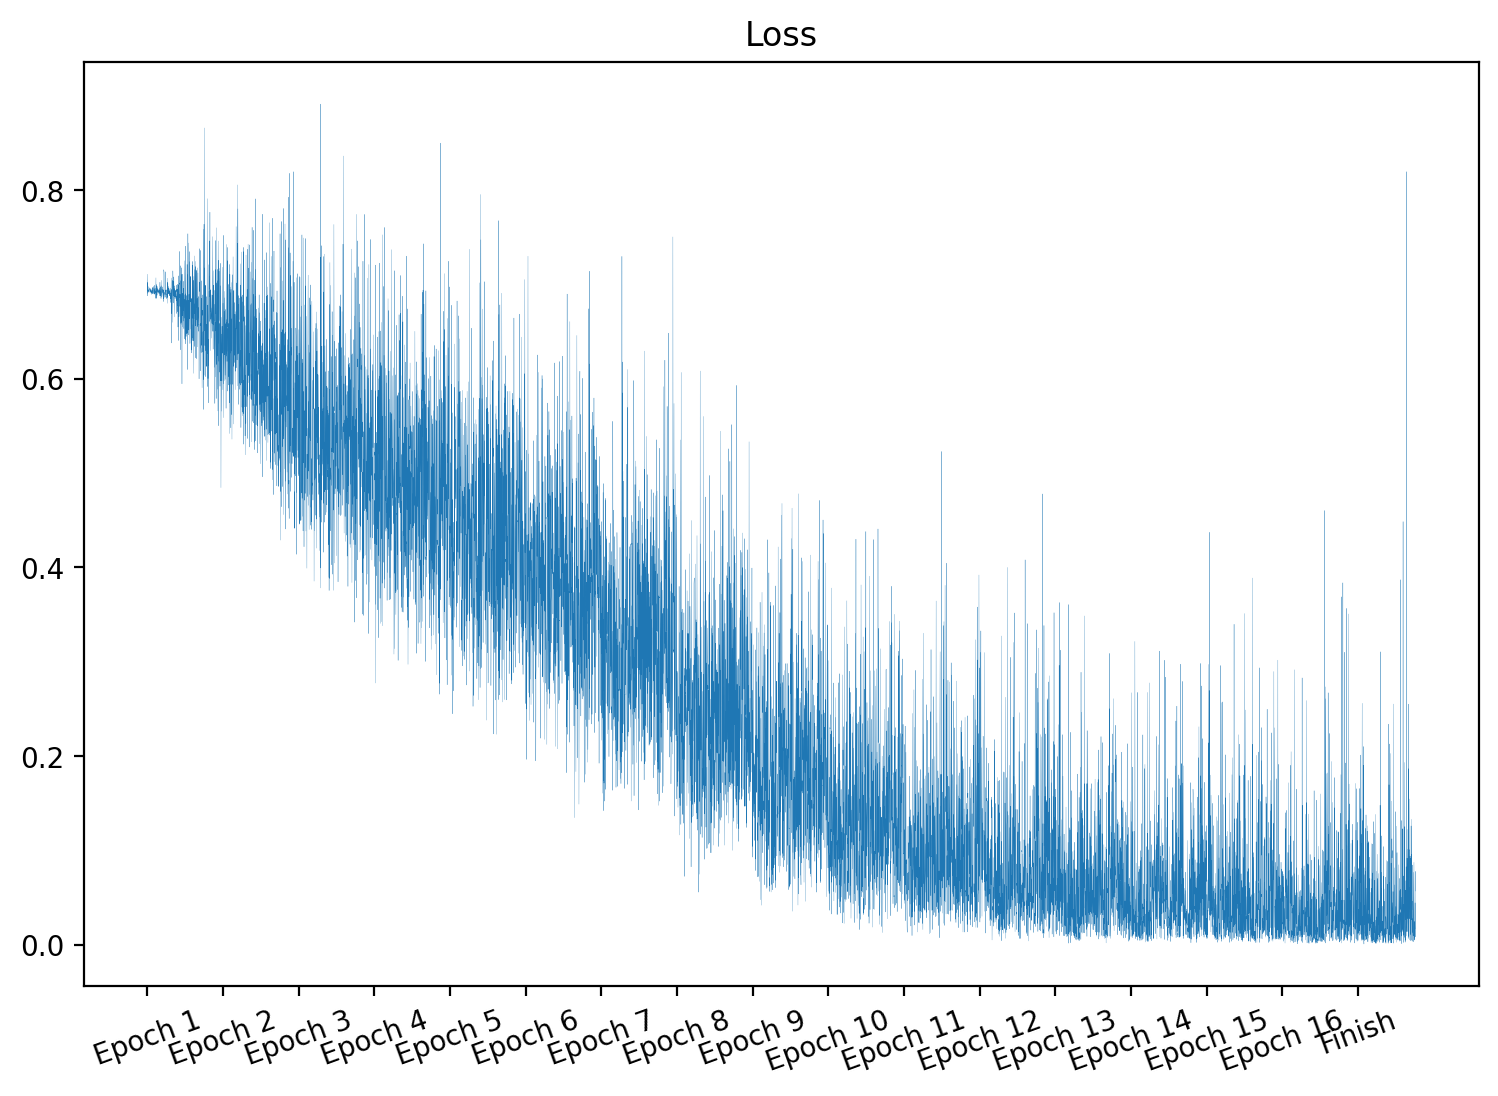

In [17]:
plt.figure(dpi=200, figsize=(9, 6))
plt.title('Loss')
plt.plot(range(len(loss_)), [x.cpu().detach() for x in loss_], linewidth=0.1)
plt.xticks(range(0, len(loss_)+1, 625), [f'Epoch {x+1}' for x in range(len(loss_)//625)]+['Finish'], rotation=20)

In [18]:
for ind, stat in enumerate(accuracy):
    print(f'Epoch {ind+1} test acc: {stat[0]}%, train acc: {stat[1]}%')

Epoch 1 test acc: 63.54%, train acc: 64.44644464446445%
Epoch 2 test acc: 69.74%, train acc: 72.47724772477248%
Epoch 3 test acc: 74.12%, train acc: 77.33273327332734%
Epoch 4 test acc: 75.26%, train acc: 79.85798579857986%
Epoch 5 test acc: 74.68%, train acc: 81.78817881788179%
Epoch 6 test acc: 76.8%, train acc: 87.18871887188719%
Epoch 7 test acc: 77.14%, train acc: 90.71907190719072%
Epoch 8 test acc: 77.48%, train acc: 94.50945094509451%
Epoch 9 test acc: 77.54%, train acc: 97.42474247424742%
Epoch 10 test acc: 77.62%, train acc: 97.43474347434743%
Epoch 11 test acc: 77.0%, train acc: 98.3998399839984%
Epoch 12 test acc: 77.54%, train acc: 98.95489548954896%
Epoch 13 test acc: 77.62%, train acc: 99.43494349434944%
Epoch 14 test acc: 76.92%, train acc: 99.17491749174917%
Epoch 15 test acc: 77.4%, train acc: 99.28492849284929%
Epoch 16 test acc: 75.76%, train acc: 98.68486848684869%


In [116]:
LOAD_PATH = './net11epoch.pth'

In [ ]:
print(image_acc(net, test_loader))

In [ ]:
print(image_acc(net, train_loader))

In [117]:
net.load_state_dict(torch.load(LOAD_PATH))

<All keys matched successfully>

In [33]:
print(image_acc(net, test_loader))

  0%|          | 0/157 [00:00<?, ?it/s]

72.28


In [15]:
print(image_acc(net, train_loader))

  0%|          | 0/625 [00:00<?, ?it/s]

99.72497249724972


# Resnet 18

In [27]:
from torchvision.models import resnet18
model = resnet18()

In [32]:
last_layer = model.fc
model.fc = nn.Linear(last_layer.in_features, 2)
model = model.to(device)

In [33]:
main_loss = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.fc.parameters(), lr=0.01)

In [34]:
loss_list = []
acc_list = []

In [35]:
learning(model, optimizer, main_loss, 3, train_loader, loss_list, acc_list)

Learning:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

In [37]:
acc_list

[[62.66, 63.95639563956396],
 [62.66, 64.24142414241425],
 [53.74, 54.13041304130413]]

# Transfer learning
## Feature extraction

In [12]:
from torchvision.models import resnet101, ResNet101_Weights

model = resnet101(weights=ResNet101_Weights.IMAGENET1K_V2)

In [ ]:
for param in model.parameters():
    param.requires_grad = False
    
last_layer = model.fc
model.fc = nn.Linear(last_layer.in_features, 2)
model.to(device)

In [14]:
main_loss = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.fc.parameters(), lr=0.005)

In [17]:
loss_list = []
acc_list = []
learning(model, optimizer, main_loss, 3, train_loader, loss_list, acc_list)

Learning:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

([<matplotlib.axis.XTick at 0x2f187bf70>,
 [Text(0, 0, 'Epoch 1'),
  Text(625, 0, 'Epoch 2'),
  Text(1250, 0, 'Epoch 3'),
  Text(1875, 0, 'Finish')])

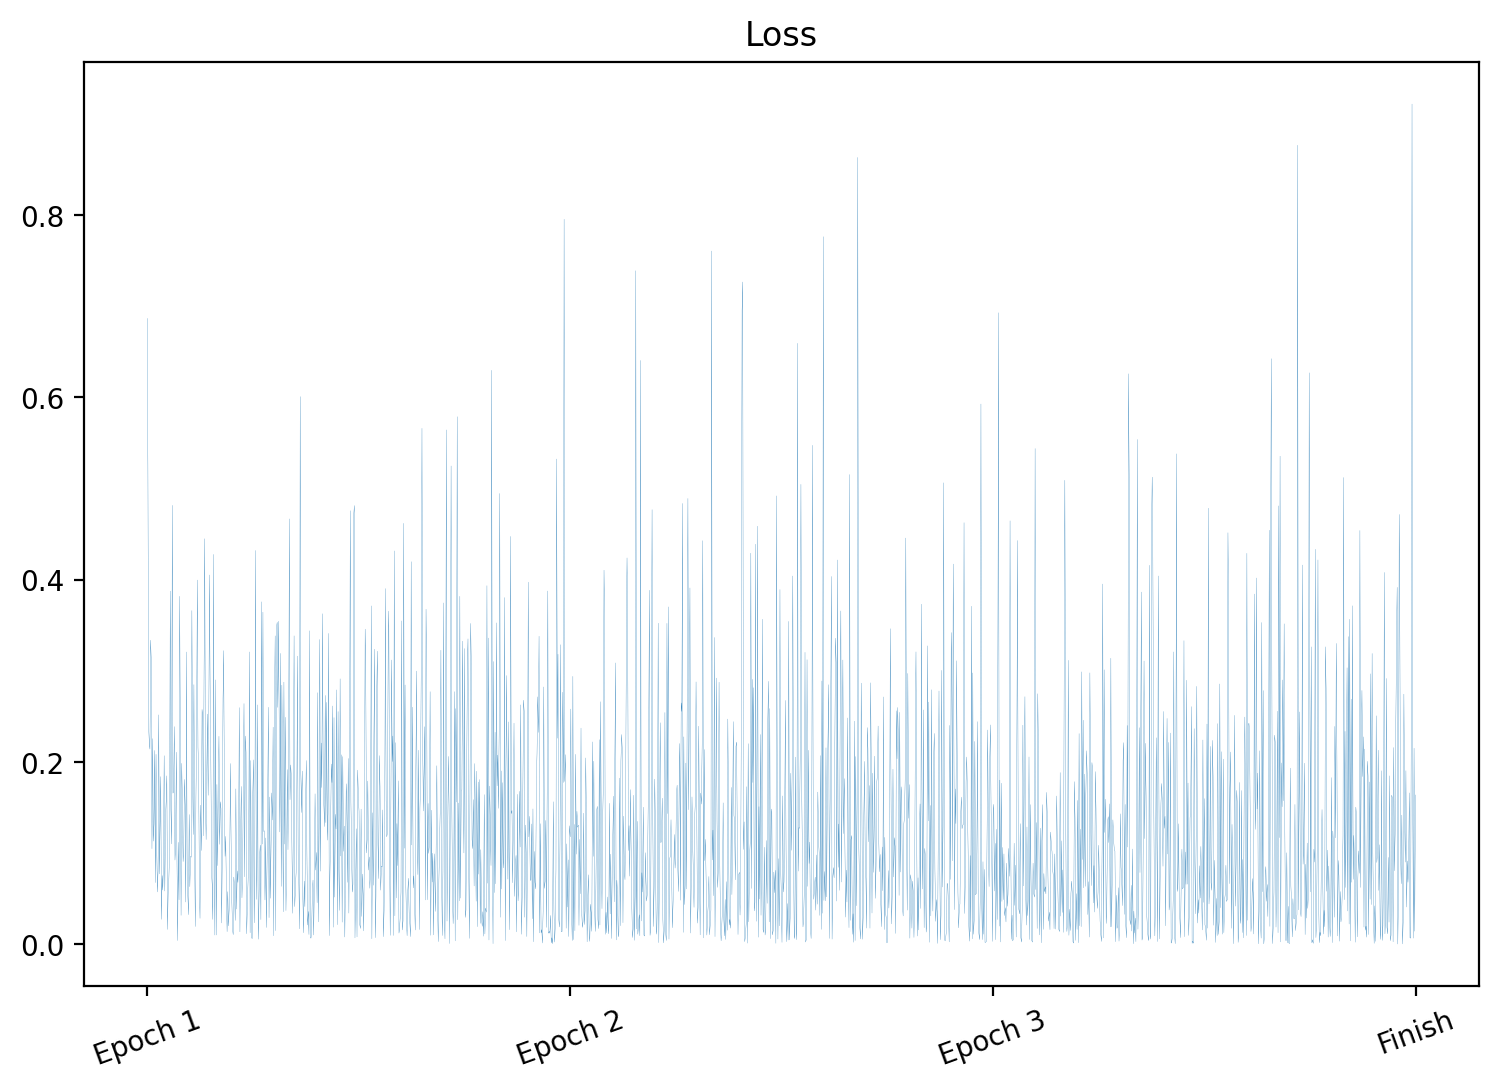

In [18]:
plt.figure(dpi=200, figsize=(9, 6))
plt.title('Loss')
plt.plot(range(len(loss_list)), [x.cpu().detach() for x in loss_list], linewidth=0.1)
plt.xticks(range(0, len(loss_list)+1, 625), [f'Epoch {x+1}' for x in range(len(loss_list)//625)]+['Finish'], rotation=20)

## Finetuning

In [22]:
from torchvision.models import resnet18, ResNet18_Weights

model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/bolevard/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████████████████████████████████| 44.7M/44.7M [00:07<00:00, 5.91MB/s]


In [ ]:
last_layer = model.fc
model.fc = nn.Linear(last_layer.in_features, 2)
model.to(device)

In [25]:
main_loss = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)

In [26]:
loss_list = []
acc_list = []
learning(model, optimizer, main_loss, 10, train_loader, loss_list, acc_list)

Learning:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/625 [00:00<?, ?it/s]

KeyboardInterrupt: 

([<matplotlib.axis.XTick at 0x15d6851f0>,
 [Text(0, 0, 'Epoch 1'),
  Text(625, 0, 'Epoch 2'),
  Text(1250, 0, 'Epoch 3'),
  Text(1875, 0, 'Finish')])

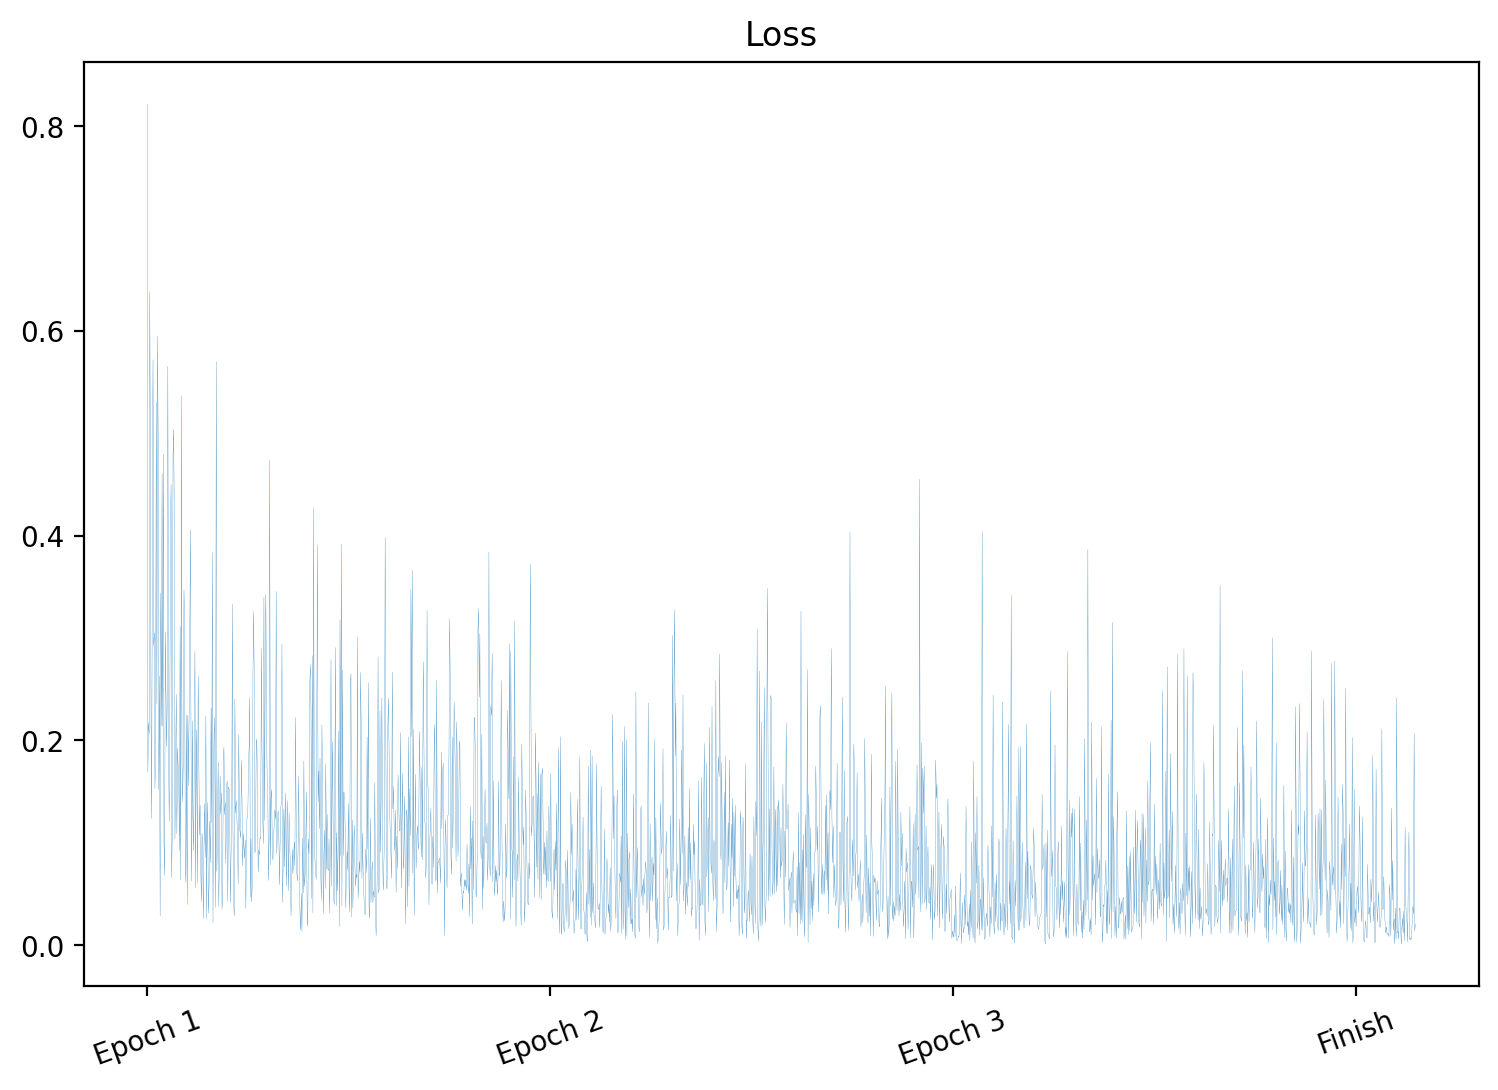

In [27]:
plt.figure(dpi=200, figsize=(9, 6))
plt.title('Loss')
plt.plot(range(len(loss_list)), [x.cpu().detach() for x in loss_list], linewidth=0.1)
plt.xticks(range(0, len(loss_list)+1, 625), [f'Epoch {x+1}' for x in range(len(loss_list)//625)]+['Finish'], rotation=20)

# Prediction section

In [74]:
from torchvision.models import resnet34

In [76]:
model = resnet34()

In [80]:
last_layer = model.fc
model.fc = nn.Linear(last_layer.in_features, 2)
model.load_state_dict(torch.load('NET.pth', map_location=device))
model.to(device);

In [85]:
image = PIL.Image.open('cat_.jpg').convert('RGB')

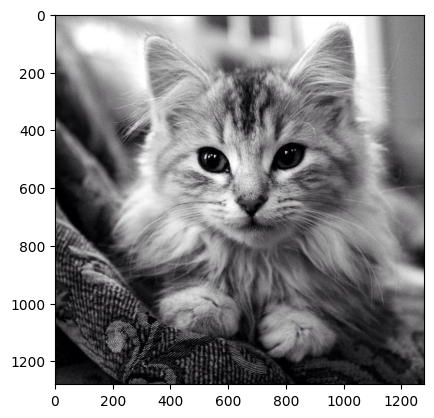

In [86]:
plt.imshow(image)

In [87]:
def predict(model, image):
    model.eval()
    image = transform(image)
    image = image.reshape([1, 3, 150, 150])
    output = model(image.to(device))
    _, predicted = torch.max(output.data, 1)
    return predicted
    
    # return

In [88]:
predict(model, image)

tensor([0], device='mps:0')